# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


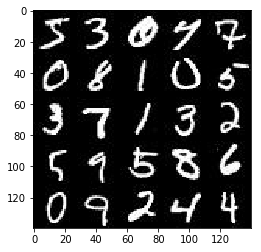

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

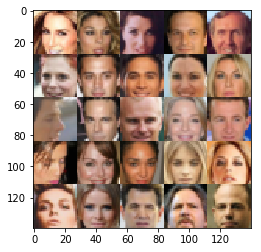

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #The idea to use the xavier initializer came from a forum entry
        first_layer = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        first_layer = tf.maximum(first_layer * alpha, first_layer)
        
        second_layer = tf.layers.conv2d(first_layer, 128, 5, strides=2, padding='same')
        second_layer = tf.layers.batch_normalization(second_layer, training=True)
        second_layer = tf.maximum(second_layer * alpha, second_layer)
        
        third_layer = tf.layers.conv2d(second_layer, 256, 5, strides=2, padding='same')
        third_layer = tf.layers.batch_normalization(third_layer, training=True)
        third_layer = tf.maximum(third_layer * alpha, third_layer)
        
        flattened = tf.reshape(third_layer, (-1, 4*4*256))
        logits = tf.layers.dense(flattened, 1)
        
        output = tf.sigmoid(logits)
                                                
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

C:\Anaconda3\envs\tflearn\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = .2
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        first_layer = tf.layers.dense(z, 4*4*512)
        first_layer = tf.reshape(first_layer, (-1, 2, 2, 512))
        first_layer = tf.layers.batch_normalization(first_layer, training=is_train)
        #print(first_layer.shape)
        
        #The idea to use the xavier initializer came from a forum entry
        second_layer = tf.layers.conv2d_transpose(first_layer, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        second_layer = tf.layers.batch_normalization(second_layer, training=is_train)
        second_layer = tf.maximum(second_layer * alpha, second_layer)
        #print(second_layer.shape)
        
        third_layer = tf.layers.conv2d_transpose(second_layer, 128, 5, strides=3, padding='valid')
        third_layer = tf.layers.batch_normalization(third_layer, training=is_train)
        third_layer = tf.maximum(third_layer * alpha, third_layer)
        #print(third_layer.shape)
        
        logits = tf.layers.conv2d_transpose(third_layer, out_channel_dim, 5, strides=2, padding='same')
        #print(logits.shape)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False) 
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    #print(input_real)
    #print(g_model)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                
                
                if steps % 10 == 0:
                    # Get the losses and print them out after 10 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                    losses.append((train_loss_d, train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 8, input_z, data_shape[3], data_image_mode)

    return losses

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.2188... Generator Loss: 17.7103
Epoch 1/2... Discriminator Loss: 0.1524... Generator Loss: 5.0059
Epoch 1/2... Discriminator Loss: 0.4541... Generator Loss: 6.2237
Epoch 1/2... Discriminator Loss: 0.7057... Generator Loss: 1.7975
Epoch 1/2... Discriminator Loss: 1.2134... Generator Loss: 0.6770
Epoch 1/2... Discriminator Loss: 0.9428... Generator Loss: 0.6639
Epoch 1/2... Discriminator Loss: 0.7356... Generator Loss: 1.4102
Epoch 1/2... Discriminator Loss: 2.8559... Generator Loss: 8.8141
Epoch 1/2... Discriminator Loss: 0.3267... Generator Loss: 2.2539
Epoch 1/2... Discriminator Loss: 1.3205... Generator Loss: 0.6127


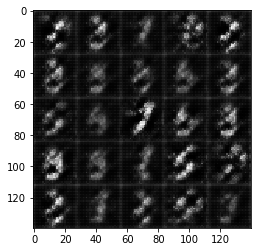

Epoch 1/2... Discriminator Loss: 0.6182... Generator Loss: 2.4519
Epoch 1/2... Discriminator Loss: 0.9421... Generator Loss: 1.8588
Epoch 1/2... Discriminator Loss: 1.7275... Generator Loss: 0.2948
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 2.9848
Epoch 1/2... Discriminator Loss: 0.7468... Generator Loss: 1.2143
Epoch 1/2... Discriminator Loss: 0.5137... Generator Loss: 1.7460
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 0.6952
Epoch 1/2... Discriminator Loss: 1.1145... Generator Loss: 0.8035
Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 3.7677
Epoch 1/2... Discriminator Loss: 0.9470... Generator Loss: 2.2686


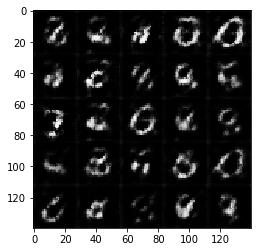

Epoch 1/2... Discriminator Loss: 1.1390... Generator Loss: 0.8196
Epoch 1/2... Discriminator Loss: 1.2907... Generator Loss: 0.5872
Epoch 1/2... Discriminator Loss: 0.9365... Generator Loss: 2.8096
Epoch 1/2... Discriminator Loss: 0.7879... Generator Loss: 1.0302
Epoch 1/2... Discriminator Loss: 0.8870... Generator Loss: 0.9691
Epoch 1/2... Discriminator Loss: 0.6156... Generator Loss: 2.7114
Epoch 1/2... Discriminator Loss: 0.6793... Generator Loss: 1.9566
Epoch 1/2... Discriminator Loss: 1.1966... Generator Loss: 0.5393
Epoch 1/2... Discriminator Loss: 1.4421... Generator Loss: 0.3794
Epoch 1/2... Discriminator Loss: 0.6658... Generator Loss: 1.1730


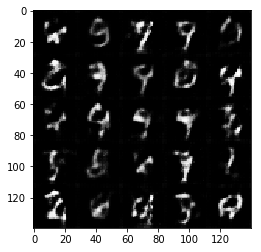

Epoch 1/2... Discriminator Loss: 0.7560... Generator Loss: 2.3545
Epoch 1/2... Discriminator Loss: 0.9674... Generator Loss: 1.4393
Epoch 1/2... Discriminator Loss: 0.5364... Generator Loss: 1.9254
Epoch 1/2... Discriminator Loss: 1.6024... Generator Loss: 0.4112
Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 1.5017
Epoch 1/2... Discriminator Loss: 1.1702... Generator Loss: 0.7269
Epoch 1/2... Discriminator Loss: 1.1807... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 0.7803... Generator Loss: 1.0622
Epoch 1/2... Discriminator Loss: 0.8639... Generator Loss: 1.6120
Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 1.0860


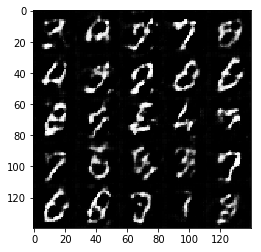

Epoch 1/2... Discriminator Loss: 0.6767... Generator Loss: 1.2764
Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 1.1356
Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 1.1842
Epoch 1/2... Discriminator Loss: 1.6888... Generator Loss: 3.7140
Epoch 1/2... Discriminator Loss: 0.6457... Generator Loss: 1.6003
Epoch 1/2... Discriminator Loss: 0.9934... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 0.7553... Generator Loss: 1.0565
Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 0.6952
Epoch 1/2... Discriminator Loss: 0.7884... Generator Loss: 1.6195
Epoch 1/2... Discriminator Loss: 0.8932... Generator Loss: 1.1993


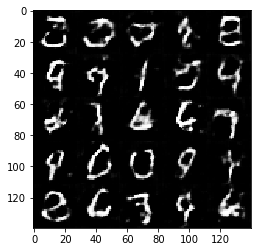

Epoch 1/2... Discriminator Loss: 0.8745... Generator Loss: 1.3718
Epoch 1/2... Discriminator Loss: 0.7766... Generator Loss: 1.1217
Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.4291
Epoch 1/2... Discriminator Loss: 0.9088... Generator Loss: 0.9423
Epoch 1/2... Discriminator Loss: 0.7997... Generator Loss: 1.9576
Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 1.2757
Epoch 1/2... Discriminator Loss: 0.9548... Generator Loss: 0.7581
Epoch 1/2... Discriminator Loss: 0.8644... Generator Loss: 1.3608
Epoch 1/2... Discriminator Loss: 0.8005... Generator Loss: 1.3048
Epoch 1/2... Discriminator Loss: 0.9348... Generator Loss: 2.1057


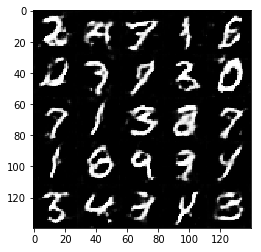

Epoch 1/2... Discriminator Loss: 0.9065... Generator Loss: 0.9722
Epoch 1/2... Discriminator Loss: 0.8064... Generator Loss: 1.4619
Epoch 1/2... Discriminator Loss: 1.0369... Generator Loss: 0.8107
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 1.1951
Epoch 1/2... Discriminator Loss: 0.9964... Generator Loss: 0.7903
Epoch 1/2... Discriminator Loss: 2.6867... Generator Loss: 0.1133
Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: 0.7620
Epoch 1/2... Discriminator Loss: 0.8672... Generator Loss: 1.6104
Epoch 1/2... Discriminator Loss: 0.9208... Generator Loss: 0.7611
Epoch 1/2... Discriminator Loss: 0.9443... Generator Loss: 1.7018


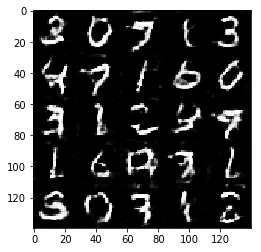

Epoch 1/2... Discriminator Loss: 0.9016... Generator Loss: 0.8347
Epoch 1/2... Discriminator Loss: 1.5011... Generator Loss: 0.4457
Epoch 1/2... Discriminator Loss: 0.7635... Generator Loss: 1.3952
Epoch 1/2... Discriminator Loss: 1.1208... Generator Loss: 0.5490
Epoch 1/2... Discriminator Loss: 0.9202... Generator Loss: 0.8793
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 1.1405
Epoch 1/2... Discriminator Loss: 0.7372... Generator Loss: 1.1815
Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 0.5618
Epoch 1/2... Discriminator Loss: 0.9103... Generator Loss: 0.7485
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.5053


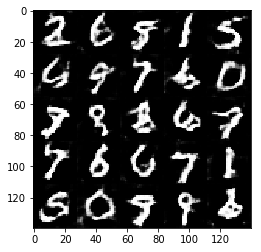

Epoch 1/2... Discriminator Loss: 0.9263... Generator Loss: 1.3773
Epoch 1/2... Discriminator Loss: 0.9422... Generator Loss: 1.1645
Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 0.4502
Epoch 1/2... Discriminator Loss: 0.7563... Generator Loss: 0.9253
Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 0.7918
Epoch 1/2... Discriminator Loss: 2.5491... Generator Loss: 0.1371
Epoch 1/2... Discriminator Loss: 1.5463... Generator Loss: 1.0406
Epoch 1/2... Discriminator Loss: 0.6193... Generator Loss: 2.0160
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.1344
Epoch 1/2... Discriminator Loss: 1.1981... Generator Loss: 2.3442


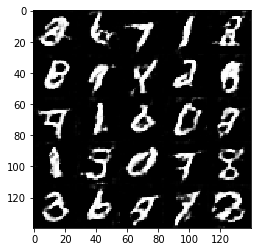

Epoch 1/2... Discriminator Loss: 1.0009... Generator Loss: 0.7169
Epoch 1/2... Discriminator Loss: 0.8349... Generator Loss: 1.1530
Epoch 1/2... Discriminator Loss: 0.9601... Generator Loss: 0.7858
Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 0.4245
Epoch 2/2... Discriminator Loss: 0.8211... Generator Loss: 1.4826
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 0.8327
Epoch 2/2... Discriminator Loss: 0.9421... Generator Loss: 0.8680
Epoch 2/2... Discriminator Loss: 1.8008... Generator Loss: 0.2606
Epoch 2/2... Discriminator Loss: 1.1170... Generator Loss: 1.0986
Epoch 2/2... Discriminator Loss: 0.9875... Generator Loss: 0.7946


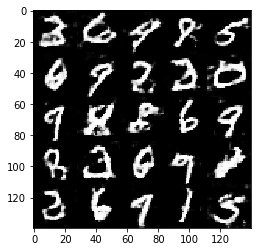

Epoch 2/2... Discriminator Loss: 1.0678... Generator Loss: 0.8335
Epoch 2/2... Discriminator Loss: 0.8023... Generator Loss: 1.4775
Epoch 2/2... Discriminator Loss: 0.9794... Generator Loss: 0.9287
Epoch 2/2... Discriminator Loss: 1.4360... Generator Loss: 0.3969
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 0.5205
Epoch 2/2... Discriminator Loss: 1.2158... Generator Loss: 0.9301
Epoch 2/2... Discriminator Loss: 0.9106... Generator Loss: 0.9242
Epoch 2/2... Discriminator Loss: 1.0717... Generator Loss: 0.8004
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 1.2629
Epoch 2/2... Discriminator Loss: 0.8830... Generator Loss: 1.0036


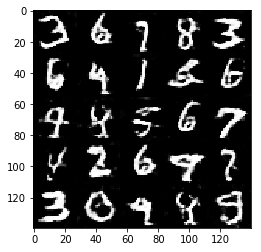

Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 1.1811
Epoch 2/2... Discriminator Loss: 0.8445... Generator Loss: 1.0225
Epoch 2/2... Discriminator Loss: 1.1601... Generator Loss: 1.3078
Epoch 2/2... Discriminator Loss: 0.9057... Generator Loss: 1.2393
Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 0.6574
Epoch 2/2... Discriminator Loss: 1.1119... Generator Loss: 0.5773
Epoch 2/2... Discriminator Loss: 2.0825... Generator Loss: 0.2303
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 0.5263
Epoch 2/2... Discriminator Loss: 0.8364... Generator Loss: 1.2807
Epoch 2/2... Discriminator Loss: 1.1604... Generator Loss: 0.6781


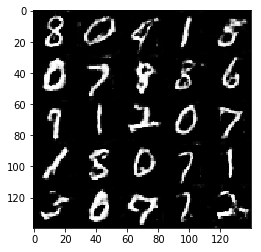

Epoch 2/2... Discriminator Loss: 1.9706... Generator Loss: 0.1973
Epoch 2/2... Discriminator Loss: 1.1112... Generator Loss: 1.2505
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 0.8515
Epoch 2/2... Discriminator Loss: 1.1121... Generator Loss: 0.6350
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 0.8304
Epoch 2/2... Discriminator Loss: 1.0631... Generator Loss: 1.9189
Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 0.4748
Epoch 2/2... Discriminator Loss: 0.9477... Generator Loss: 2.0292
Epoch 2/2... Discriminator Loss: 0.9201... Generator Loss: 0.8085
Epoch 2/2... Discriminator Loss: 0.9314... Generator Loss: 1.4201


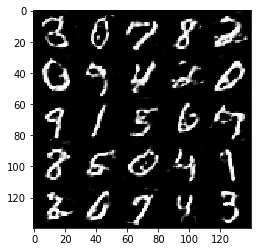

Epoch 2/2... Discriminator Loss: 0.9219... Generator Loss: 1.2582
Epoch 2/2... Discriminator Loss: 2.1224... Generator Loss: 2.5740
Epoch 2/2... Discriminator Loss: 1.0129... Generator Loss: 1.5072
Epoch 2/2... Discriminator Loss: 0.9827... Generator Loss: 0.9305
Epoch 2/2... Discriminator Loss: 1.1075... Generator Loss: 0.7208
Epoch 2/2... Discriminator Loss: 1.3180... Generator Loss: 1.4250
Epoch 2/2... Discriminator Loss: 0.8270... Generator Loss: 1.5297
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 0.8745
Epoch 2/2... Discriminator Loss: 0.8670... Generator Loss: 0.9408
Epoch 2/2... Discriminator Loss: 1.1169... Generator Loss: 2.1621


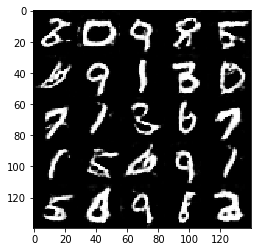

Epoch 2/2... Discriminator Loss: 0.9182... Generator Loss: 0.8098
Epoch 2/2... Discriminator Loss: 1.4220... Generator Loss: 2.5612
Epoch 2/2... Discriminator Loss: 0.9936... Generator Loss: 1.1401
Epoch 2/2... Discriminator Loss: 1.1160... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 0.9263
Epoch 2/2... Discriminator Loss: 1.4104... Generator Loss: 0.5243
Epoch 2/2... Discriminator Loss: 0.8400... Generator Loss: 1.3224
Epoch 2/2... Discriminator Loss: 0.9767... Generator Loss: 0.7456
Epoch 2/2... Discriminator Loss: 1.0097... Generator Loss: 0.7173
Epoch 2/2... Discriminator Loss: 1.1336... Generator Loss: 0.6448


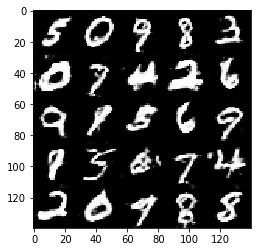

Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 0.9300
Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 0.4365
Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 2.2395
Epoch 2/2... Discriminator Loss: 0.9602... Generator Loss: 1.2923
Epoch 2/2... Discriminator Loss: 0.9714... Generator Loss: 0.7602
Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 1.6448
Epoch 2/2... Discriminator Loss: 1.2445... Generator Loss: 0.5064
Epoch 2/2... Discriminator Loss: 1.0144... Generator Loss: 1.5628
Epoch 2/2... Discriminator Loss: 1.0749... Generator Loss: 0.9072
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 0.9105


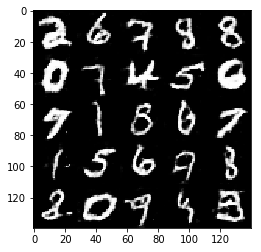

Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 0.9624
Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 1.3357
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 1.7337
Epoch 2/2... Discriminator Loss: 1.4369... Generator Loss: 0.4154
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 0.8489
Epoch 2/2... Discriminator Loss: 1.0930... Generator Loss: 0.5857
Epoch 2/2... Discriminator Loss: 0.8716... Generator Loss: 0.9263
Epoch 2/2... Discriminator Loss: 0.6685... Generator Loss: 1.1662
Epoch 2/2... Discriminator Loss: 1.6245... Generator Loss: 2.1432
Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 0.4595


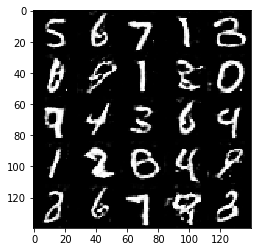

Epoch 2/2... Discriminator Loss: 0.9388... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 0.9242... Generator Loss: 0.9631
Epoch 2/2... Discriminator Loss: 1.1660... Generator Loss: 0.7725
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 2.2356
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 1.4028
Epoch 2/2... Discriminator Loss: 0.7428... Generator Loss: 1.3836
Epoch 2/2... Discriminator Loss: 0.9776... Generator Loss: 0.9041
Epoch 2/2... Discriminator Loss: 1.6668... Generator Loss: 0.3974
Epoch 2/2... Discriminator Loss: 0.8548... Generator Loss: 0.8814
Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 0.5535


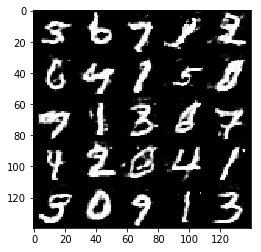

Epoch 2/2... Discriminator Loss: 1.2753... Generator Loss: 0.6038
Epoch 2/2... Discriminator Loss: 0.8781... Generator Loss: 0.7693
Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 0.7299
Epoch 2/2... Discriminator Loss: 0.9794... Generator Loss: 0.7605
Epoch 2/2... Discriminator Loss: 1.1686... Generator Loss: 1.1646
Epoch 2/2... Discriminator Loss: 1.0114... Generator Loss: 1.0665
Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 1.0639


In [12]:
batch_size = 64
z_dim = 50
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 4.6895... Generator Loss: 0.0142
Epoch 1/1... Discriminator Loss: 2.7478... Generator Loss: 0.3841
Epoch 1/1... Discriminator Loss: 0.2253... Generator Loss: 10.7883
Epoch 1/1... Discriminator Loss: 0.1173... Generator Loss: 3.4031
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 1.9034
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 7.0675
Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 1.9288
Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 2.3831
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 2.6902


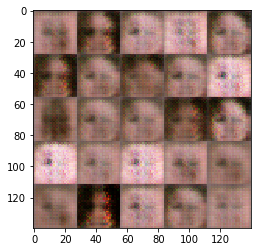

Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.3443
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 2.9379
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 2.3253
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.7914
Epoch 1/1... Discriminator Loss: 0.6427... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.5943... Generator Loss: 0.3606
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 1.9256
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.4590


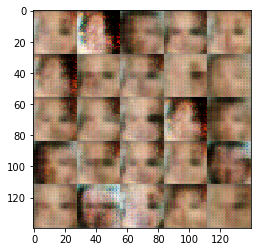

Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 1.7319... Generator Loss: 0.3041
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 0.6880... Generator Loss: 1.9011
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 1.8140
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 1.4353
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.6722
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.7959


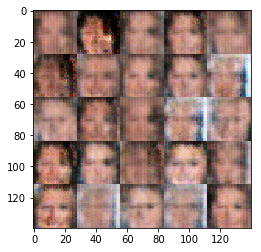

Epoch 1/1... Discriminator Loss: 1.6004... Generator Loss: 0.3309
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 1.6581
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 1.3873
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.6370


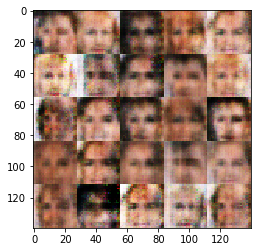

Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 1.4195
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 1.4755
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6183


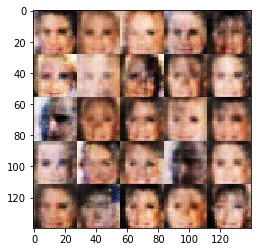

Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.1770
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 1.0212
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 1.4134


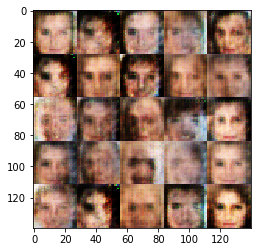

Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.3176
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.3583
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.6514


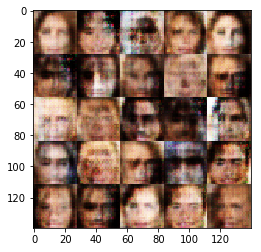

Epoch 1/1... Discriminator Loss: 1.6634... Generator Loss: 0.3395
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 1.1289
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.5665


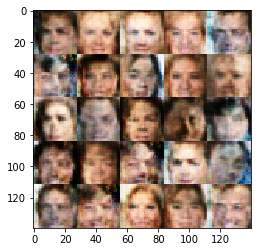

Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 1.3401
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 1.3297
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 1.4201
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.8537


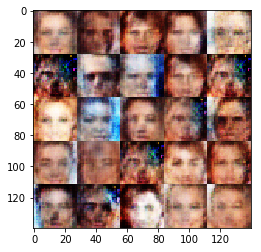

Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 1.3191
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 1.1608
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.7903


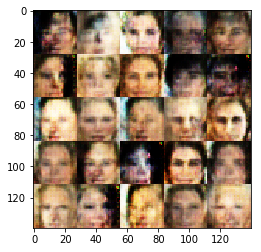

Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 1.5707
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 1.1784
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 1.1359


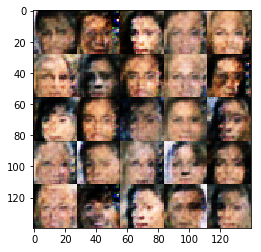

Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.4397
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 1.3524
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 1.2198
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 1.3392
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.8852


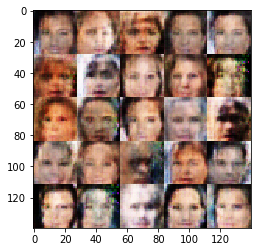

Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 1.6506
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 2.0038
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.8719


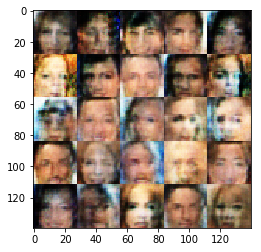

Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.1228
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 1.2093
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 1.0172


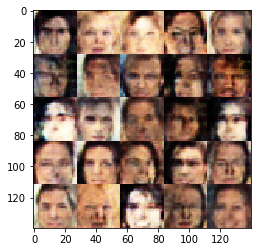

Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 1.7778
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.4549
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 1.5923
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 1.1425
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.9326


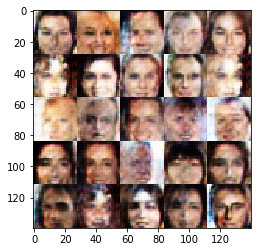

Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.4054
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.4668
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 2.1166... Generator Loss: 0.1768


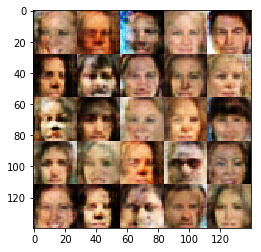

Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.3707
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 0.9786


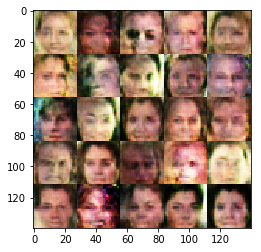

Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.2974
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.3804
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 1.4662


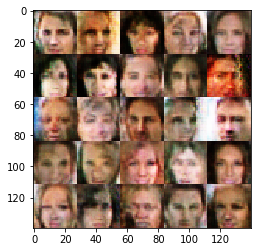

Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 1.7334
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 1.4247
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 0.8130


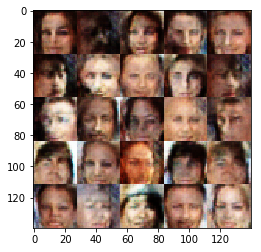

Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.0190
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 1.1275


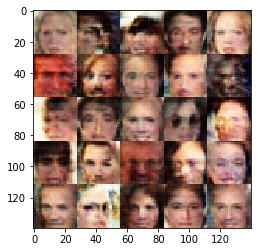

Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.4578
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.5431
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.4567


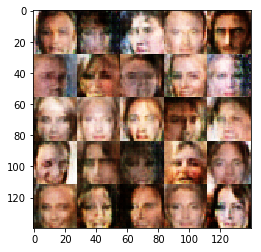

Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 1.2688
Epoch 1/1... Discriminator Loss: 1.7041... Generator Loss: 0.2577
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.5021


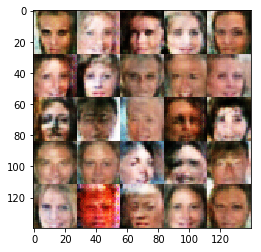

Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.1921
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 1.2219
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.3111
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 0.8716


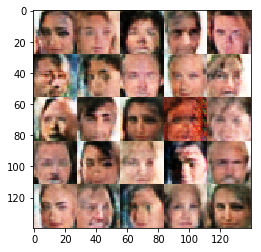

Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.2988
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.9099... Generator Loss: 0.2247
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.1827


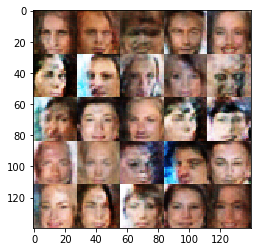

Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 1.7006
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.8857


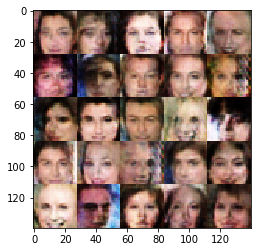

Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.8571... Generator Loss: 2.3401
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.5670
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.1823


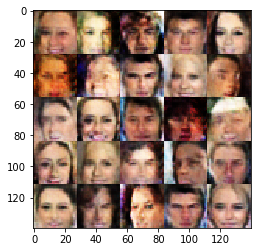

Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.3712
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.9238


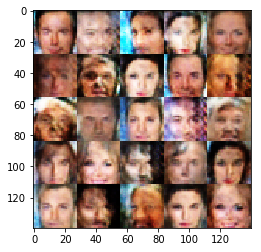

Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.2607
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.4362
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.0669
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.4456
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.4350
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 1.1800


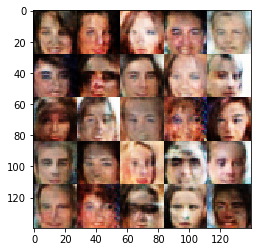

Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.4891
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 1.1519
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 0.9487


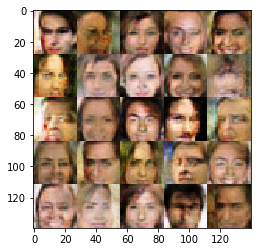

Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.3934
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 1.4765
Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 0.7067


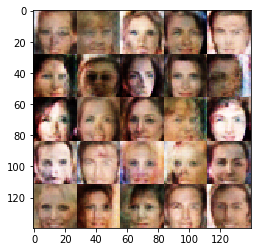

Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.3950
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 1.2630
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.6119
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.3639
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.5545


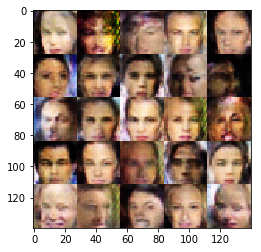

Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.4181
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.1477
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.6704


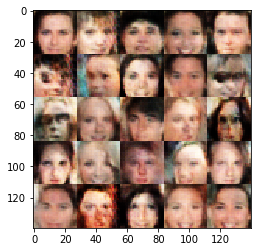

Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 1.6131


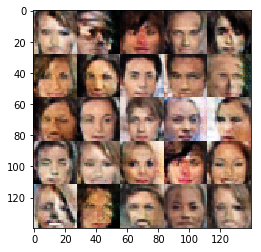

Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.3360
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.4455
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.5195
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.2181
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.5026
Epoch 1/1... Discriminator Loss: 1.7112... Generator Loss: 0.2622


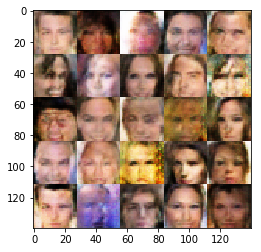

Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 1.3820
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.7112


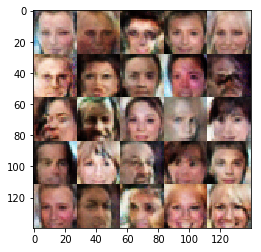

Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 1.2764
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 1.3338
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.0730


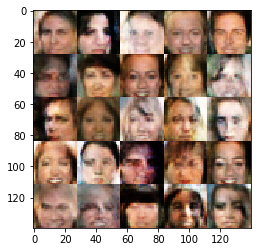

Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 1.0338
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 1.5487
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 1.3079
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.6625


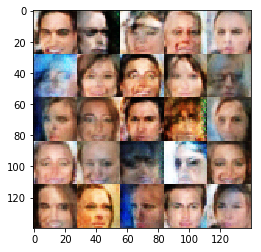

Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.5078


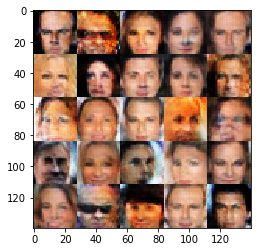

Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.0669
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.9192


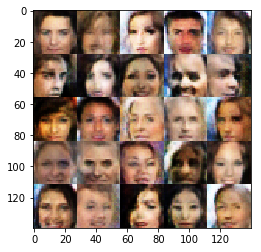

Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 1.1760
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.6116


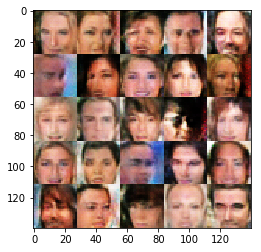

Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.4908
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 1.2724
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 1.3101
Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 0.6938


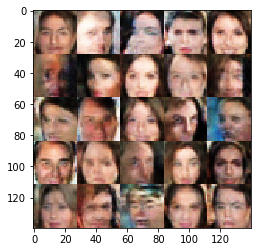

Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 1.2687
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 1.1711


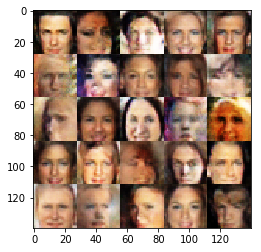

Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 1.2799
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.5918


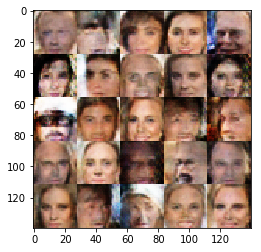

Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 1.6122
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.4446


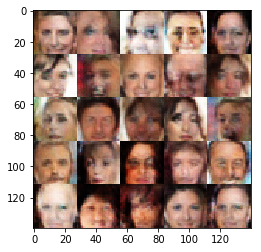

Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.4688
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.7619


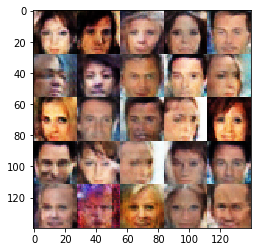

Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.3595
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 1.3593
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.5231
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.3000
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 1.2163
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.9038


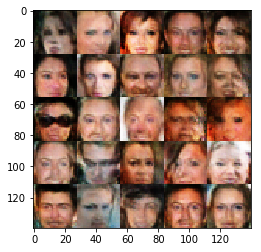

Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.4114
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.4829
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.6674


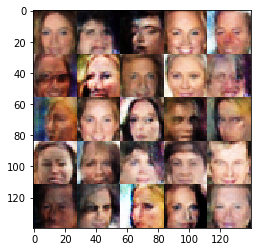

Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.1818
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 1.0879


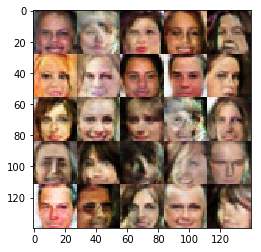

Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.3148
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 0.7091


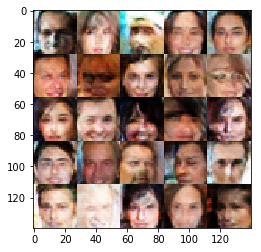

Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 1.3596


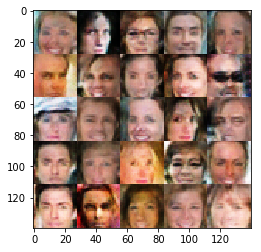

Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.3017
Epoch 1/1... Discriminator Loss: 1.5547... Generator Loss: 0.3201
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 1.4520
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 1.1135


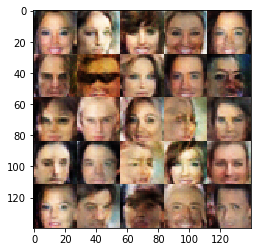

Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.4829
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 1.0229


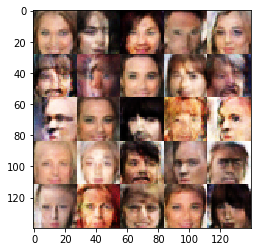

Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 1.5170
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.4118
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.7282


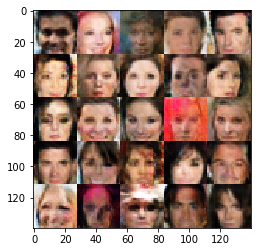

Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.9677
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 1.6876
Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 1.0762


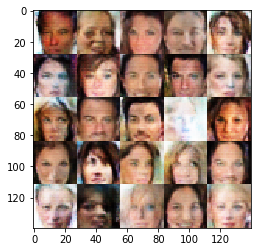

Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 1.3543
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.5386


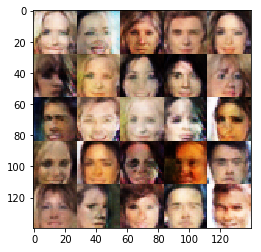

Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.5836
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 1.1918
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.8602


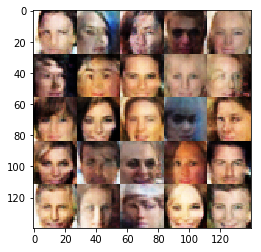

Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.4100
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 0.9659


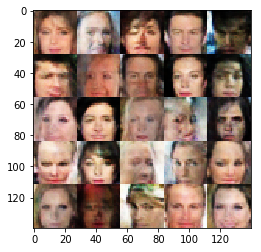

Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.4213
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.9851


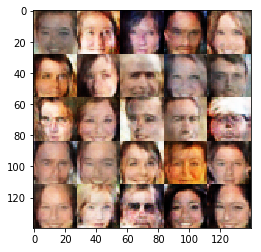

Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 0.8134


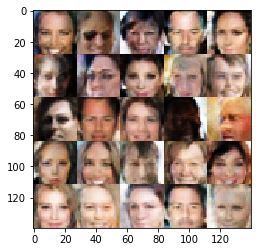

Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 1.1078
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.6982


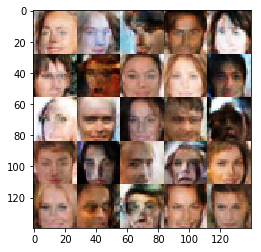

Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.3140
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 1.9518
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.7598


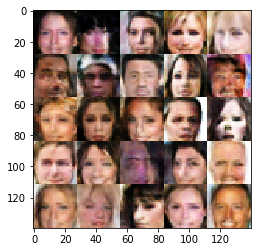

Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.4308
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.7630


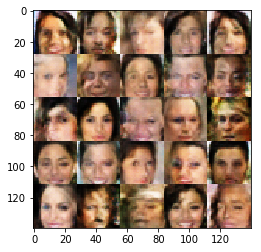

Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.5833
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.6595


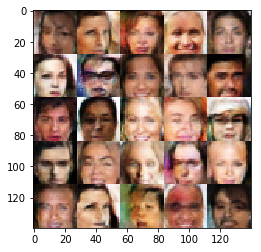

Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 1.7123
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 0.8688


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。